In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.utils.fixes import loguniform

import scipy.stats as stats

from ts_utils import OOSR2

In [2]:
df = pd.read_csv("../_data/time_series.csv", index_col="Date")
df.index = pd.to_datetime(df.index)
df = df.round(4)

train = df.loc[df.index <= "2009.12.31"]
test = df.loc[df.index > "2009.12.31"]

train.shape, test.shape

((357, 52), (158, 52))

In [7]:
res = -0.1

while res < 0.035:
    bestparams = []
    predictions = []
    naive_predictions = []
    train_end_dates = []

    naive_mean = DummyRegressor(strategy="mean")
    estimator = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

    for i in np.arange(357,515,6): 
        train_realtime = df.iloc[:i]
        test_realtime = df.iloc[i:i+6]

        X_train, y_train = train_realtime.drop(["EXCESS_RETURN_T+1"], axis=1).values, train_realtime["EXCESS_RETURN_T+1"].values
        X_test, y_test = test_realtime.drop(["EXCESS_RETURN_T+1"], axis=1).values, test_realtime["EXCESS_RETURN_T+1"].values

        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('regressor', estimator)
            ])

        param_grid = {
            "regressor__n_estimators": [3],
            "regressor__learning_rate": [0.1,0.5,1],
            'regressor__loss': ["square"],
            'regressor__base_estimator__max_depth': [1], 
            "regressor__base_estimator__max_features": [40],
            "regressor__base_estimator__min_samples_split": [30],
            "regressor__base_estimator__min_samples_leaf": [30]
            }

        tscv = TimeSeriesSplit(n_splits=2)

        grid_search = RandomizedSearchCV(
            estimator=pipeline, 
            param_distributions= param_grid,
            scoring="neg_mean_squared_error",
            refit= "neg_mean_squared_error",
            cv=tscv,
            n_iter=3,
            n_jobs=-1,
            )  

        grid_search.fit(X_train, y_train)
        naive_mean.fit(X_train, y_train)

        predictions.extend(grid_search.predict(X_test).tolist())
        naive_predictions.extend(naive_mean.predict(X_test).tolist())
        train_end_dates.append(pd.to_datetime(train_realtime.index[-1]).strftime('%Y-%m-%d'))
        bestparams.append(grid_search.best_params_)

    res = OOSR2(test["EXCESS_RETURN_T+1"].values, np.array(predictions), np.array(naive_predictions))
    print(res)

-0.03410597556996042
-0.09685395909280947
-0.01993912030177447
-0.025713638974985242
-0.02842512445883716
0.018932953829806087
-0.009152546242623849
-0.07236970258799169
-0.037826176187578
0.0053799649677346295
0.014307649311744108
0.010276790729676244
-0.03626118631585418
-0.01897001100241269
0.003982770493087595
-0.1115607223745283
-0.02576836791707926
-0.06060139698450384
-0.03745503313815002
-0.04961240927882016
-0.009511052662739772
-0.0056033456898265666
0.003495948869024601
0.007889213108851156
-0.02642876290619811
-0.03839601541271742
-0.11478347881436779
0.013103842267530807
-0.06383814874228055
-0.04054698041695559
-0.026258464656111924
-0.059762008304484304
-0.12461354695008775
-0.04450852071282596
-0.09731523036643619
-0.03420237490760658
-0.012067647629331102
-0.0010556962222816324
-0.11606520706335699
-0.1555045709395757
-0.05746963386871551
0.00018377102209854446
-0.00774785149356072
-0.07406782807943912
-0.14812445119425388
-0.02263248042646704
-0.030485577744791437
-0.

KeyboardInterrupt: 

In [84]:
OOSR2(test["EXCESS_RETURN_T+1"].values, np.array(predictions), np.array(naive_predictions))

0.03695388676686295

[]

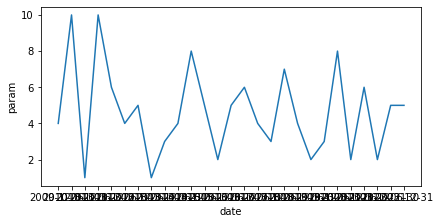

In [85]:
nlist = []
ratelist = []

for paramdict in bestparams:
    nlist.append(paramdict["regressor__n_estimators"])
    ratelist.append(paramdict["regressor__learning_rate"])
    
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.plot(train_end_dates, nlist)
ax.set_xlabel('date')
ax.set_ylabel('param')

plt.plot()

[]

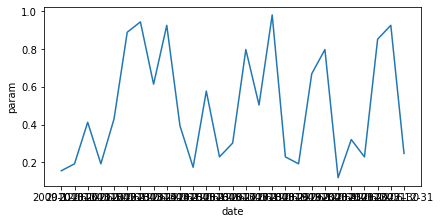

In [86]:
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.plot(train_end_dates, ratelist)
ax.set_xlabel('date')
ax.set_ylabel('param')

plt.plot()

In [87]:
rfr = pd.read_csv("../_data/rfr_02_2010_to_03_2023_158vals.csv", index_col="Date")
econeval = pd.DataFrame()
econeval["r"] = test["EXCESS_RETURN_T+1"]
econeval["r_predict"] = predictions
econeval["mean_predict"] = naive_predictions
econeval["rfr"] = rfr["RF"].values
econeval.index = rfr.index
econeval["vola_est"] = econeval["r"].rolling(window=12, closed="left").std()
econeval["w_model"] = 1/3*econeval["r_predict"]/econeval["vola_est"]**2
econeval["w_mean"] = 1/3*econeval["mean_predict"]/econeval["vola_est"]**2
econeval["w_model_cap"] = econeval["w_model"].apply(lambda x: 1 if x > 1 else (0 if x < 0 else x))
econeval["w_mean_cap"] = econeval["w_mean"].apply(lambda x: 1 if x > 1 else (0 if x < 0 else x))
econeval["rp_model"] = econeval["rfr"]+econeval["w_model_cap"]*econeval["r"]
econeval["rp_mean"] = econeval["rfr"]+econeval["w_mean_cap"]*econeval["r"]

In [88]:
econeval.dropna(axis=0,inplace=True)
u_model = econeval["rp_model"].mean() - 0.5*3*econeval["rp_mean"].std()**2
u_mean = econeval["rp_mean"].mean() - 0.5*3*econeval["rp_mean"].std()**2
annualized_gain = (u_model - u_mean)*12
monthly_sharpe = econeval["rp_model"].mean() / econeval["rp_model"].std()
sp500meanreturn = econeval["r"].mean()
sp500vol = econeval["r"].std()

print("annualized gain: ", annualized_gain)
print("monthly avg portfolio return: ", econeval["rp_model"].mean())
print("monthly volatility: ", econeval["rp_model"].std())
print("monthly sharpe: ", monthly_sharpe)
print("sp500 mean return:",sp500meanreturn)
print("sp500 vola:",sp500vol)

annualized gain:  -0.00850490329777721
monthly avg portfolio return:  0.004970767923767772
monthly volatility:  0.02840119551349058
monthly sharpe:  0.1750196720207308
sp500 mean return: 0.008317123287671233
sp500 vola: 0.0419887429242304


0.03715844376924171